In [2]:
import numpy as np

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
from torchvision.io import read_image

from transformers import CLIPProcessor, CLIPModel

In [4]:
img_path = os.path.join('../sneakers/data/golden_dataset/', str(df.image_id.iloc[-5]))
print(img_path)
image = read_image(img_path + '.png')

NameError: name 'df' is not defined

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.image_id.iloc[idx]))
        image = read_image(img_path + '.png')
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image


In [6]:
dataset = CustomImageDataset('../sneakers/data/labelled_sample.csv',
                             '../sneakers/data/golden_dataset/')

In [7]:
df = pd.read_csv('../sneakers/data/labelled_sample.csv', index_col=None)

libpng warning: iCCP: known incorrect sRGB profile


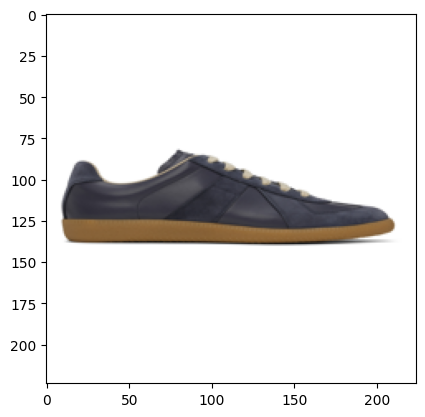

In [8]:
plt.imshow(dataset[-5].permute(1, 2, 0))
plt.show()

In [9]:
local_processor = CLIPProcessor.from_pretrained('../models/clip/', local_files_only=True)
local_model = CLIPModel.from_pretrained('../models/clip/', local_files_only=True)

In [86]:
len(dataset)

150

In [10]:
image_embeddings = local_model.get_image_features(**local_processor(images=[dataset[i] for i in range(len(dataset))], 
                                                 return_tensors="pt", 
                                                 padding=True))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [11]:
image_embeddings = image_embeddings.detach().numpy() / np.linalg.norm(image_embeddings.detach().numpy(), ord=2, axis=-1, keepdims=True)

In [12]:
image_embeddings.shape

(150, 512)

## ebmeddings to qdrant

In [23]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

client = QdrantClient(host="localhost", port=6333)

In [24]:

client.recreate_collection(
    collection_name="clip",
    vectors_config=VectorParams(size=image_embeddings.shape[1], distance=Distance.COSINE),
)

/var/folders/rn/n96315xj07s91rcy_t4k4h2r0000gn/T/ipykernel_83881/989052432.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [26]:
points=[
        PointStruct(
            id=idx,
            vector=image_embeddings[idx],
            payload={"description": df['prompt'].values[idx],
                     "image_id": int(df['image_id'].values[idx])}
        )
        for idx in range(150)
    ]

In [27]:
client.upload_points(collection_name="clip_embeddins",
                     points=points)

## test search

In [28]:
user_text = ["women's light-colored sandals over $1,000"]

In [29]:
inputs = local_processor(text=user_text,
                   return_tensors="pt", padding=True)

In [30]:
text_embeddings = local_model.get_text_features(**inputs)

In [31]:
hits = client.search(
    collection_name="clip_embeddins",
    query_vector=text_embeddings.tolist()[0],
    limit=3 
)

In [32]:
hits

[ScoredPoint(id=59, version=0, score=0.32756478, payload={'description': 'These are shoes for women from brand valentino garavani model pink rockstud mules. Item price is 1200 dollars.', 'image_id': 16171046124631563076}, vector=None, shard_key=None),
 ScoredPoint(id=103, version=1, score=0.32725972, payload={'description': 'These are shoes for women from brand valentino garavani model beige rockstud sandals. Item price is 650 dollars.', 'image_id': 15658571220667684420}, vector=None, shard_key=None),
 ScoredPoint(id=82, version=1, score=0.32682973, payload={'description': 'These are shoes for women from brand valentino garavani model beige rockstud sandals. Item price is 635 dollars.', 'image_id': 11779214054990379599}, vector=None, shard_key=None)]